In [1]:
!squeue -u aschade

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [2]:
!scancel -u aschade

In [3]:
from logging import log
from os.path import exists
from os import makedirs
import shutil
from glob import glob
from tqdm import tqdm
from retrying import retry
from time import time, sleep

import matplotlib.pyplot as plt
import matplotlib.dates as matdates
import numpy as np
import pandas as pd
pd.options.display.max_rows = 150
pd.options.display.max_columns = 50
import seaborn as sns
sns.set_style("whitegrid")

import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
# dask.config.set({
#     'distributed.workers.memory.spill':          None, 
#     'distributed.scheduler.allowed-failures':    10,
# })

########################################################################################################################
########################################################################################################################
########################################################################################################################

def getCleanDDFfromCSV(path, dt, scheduler=None):
    
    ############################## ridding of superfluous cols ###############################
    ddf = dd.read_csv(path)
    for col in dt.copy().keys():
        if col not in ddf.columns:
            del dt[col]


    ###################################### converters ########################################
    def coerceToFloat(something):
        try: return float(something)
        except ValueError: return np.nan

    def coerceToInt(something):
        try: return int(float(something))           # tries to convert string to int in decimal number system, gets confused by having to parse the comma
        except ValueError: return -1

    def coerceToStr(something):
        try: return str(something)
        except ValueError: return 'nan'

    floatColumns = [column for column, dtype in dt.items() if dtype == 'float']
    intColumns = [column for column, dtype in dt.items() if dtype == 'int']
    strColumns = [column for column, dtype in dt.items() if dtype == 'str']

    converters = {}
    converters.update(dict.fromkeys(floatColumns, coerceToFloat))
    converters.update(dict.fromkeys(intColumns, coerceToInt))
    converters.update(dict.fromkeys(strColumns, coerceToStr))


    ##################################### point to data #########################################
    ddf = dd.read_csv(

        ################# actual data stuff #################
        path, 
        usecols=dt.keys(),
        converters=converters,
        keep_default_na=True,
        

        ################# auxiliary fixes #################
        encoding='utf8',                #'utf8', #'unicode_escape', 'latin-1'
        encoding_errors='replace',      
        on_bad_lines='skip',
        # low_memory=False,             # in pandas, tells it not to read in chunks for consistent dtypes
        # blocksize=None,                 # function may file if csv contains quoted strings within field -> None tells it not to split files into multiple partitions, at cost of reduced parallelism (in fact, it totally ruins any parallelisation, turning it back to pandas basically)
        )

    if 'date' in ddf.columns:
        ddf['time'] = ddf['date'].apply(lambda text: text[-8:], meta=('date', 'object'))
        ddf['date'] = ddf['date'].apply(lambda text: text[:10], meta=('date', 'object'))
#         ddf['date'] = dd.to_datetime(
#             ddf['date'], 
#             errors='coerce', 
#             exact=False,                    # allows match to be found anywhere in string
#             infer_datetime_format=True,     # if no 'format' is given, infer it -> potential speed-up, we only look at one year at a time, when the format should be consistent
#             )

    if scheduler:
        return scheduler.persist(ddf)
    else:
        return ddf
    


########################################################################################################################
########################################################################################################################
########################################################################################################################

cluster = SLURMCluster(
    cores=12,                          
    memory='200GB',  
#     memory='1400GB',
    
    local_directory='~/scratch',
    job_extra=[
#         '--reservation=lab_rdurante_302',
        '--partition=haswell',    
        '--nodes=1',
        '--time=03:00:00',
        
        '--job-name=dask',
        '--output=dask.out', 
        '--error=dask.error', 
        '--mail-user=aaron.schade@upf.edu',
        '--mail-type=NONE', 
    ],    
    n_workers=1,                 # this is internal to one job? one node? 
    
    interface='ib0',               # workers, no diag: em1, em2, ib0,   # no workers: lo, em1.851, idrac, em3 & em4 (no ipv4)
    scheduler_options={
#         'interface': 'em1',      # it wont allow you specify both an interface AND a host address
        'host': '10.30.50.163',    # launch on this address, open dashboard on the other?
    },
)
cluster.scale(jobs=1)


scheduler = Client(cluster)
print(scheduler)
dashboardLink = scheduler.dashboard_link.replace('10.30.50.163', '10.60.110.163')
# dashboardLink = scheduler.dashboard_link
print(dashboardLink)
print(dashboardLink.replace('status', 'workers'))
print(dashboardLink.replace('status', 'graph'))

/homes/users/aschade/.local/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


<Client: 'tcp://10.30.50.163:39628' processes=0 threads=0, memory=0 B>
http://10.60.110.163:8787/status
http://10.60.110.163:8787/workers
http://10.60.110.163:8787/graph


In [4]:
sleep(2)

In [5]:
!squeue -u aschade

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          19341893   haswell     dask  aschade  R       0:01      1 mr-05-01


In [6]:
orders = dd.read_parquet('~/scratch/glovo/parquet/old_data/orders')
# dtOrders = {
#     'id':                      'int', 
#     'city':                    'str',
#     'date':                    'str', 
#     'duration':                'float', 
#     'total_distance':          'float', 
#     'store_address_id':        'float', 
#     'category':                'str', 
#     'delivery_postal_code':    'float', 
#     'hexagon_h3_hash_8':       'str', 
#     'country_code':            'str', 
#     'courier_id':              'str', 
# }
# orders = getCleanDDFfromCSV('~/scratch/glovoBucket/orders*.csv', dtOrders)
orders.head()

,id,city,duration,total_distance,store_address_id,category,delivery_postal_code,hexagon_h3_hash_8,country_code,courier_id,time
date,,,,,,,,,,,
2016-01-01,22154,BCN,47.0,0.0,NaN,QUIERO,NaN,,ES,X-27861-T,22:26:38
2016-01-01,22073,BCN,27.0,0.0,NaN,QUIERO,NaN,,ES,X-20890-T,20:11:02
2016-01-01,22123,MAD,50.0,0.0,NaN,QUIERO,NaN,,ES,X-7500-T,21:31:01
2016-01-01,22044,VAL,68.0,0.0,NaN,QUIERO,NaN,8839540a89fffff,ES,X-13621-T,15:22:10
2016-01-01,22153,MAD,30.0,0.0,NaN,QUIERO,NaN,88390cb19dfffff,ES,X-32616-T,22:26:09


In [7]:
stores = dd.read_parquet('~/scratch/glovo/parquet/old_data/stores')
# dtStores = {
#     'store_id':                 'int', 
#     'store_adress_id':          'float', 
#     'store_creation_time':      'str', 
#     'store_name':               'str',
#     'city_code':                'str', 
#     'store_type':               'str', 
#     'store_tag':                'str', 
#     'is_food':                  'bool', 
#     'store_segment':            'str',
#     'store_description':        'str', 
#     'first_order_created':      'str', 
#     'delivered_orders':         'float', 
#     }

# stores = getCleanDDFfromCSV('~/scratch/glovoBucket/stores*.csv', dtStores).rename(columns={'store_adress_id': 'store_address_id'})
stores.head()

,store_address_id,store_creation_time,store_name,city_code,store_type,store_tag,is_food,store_segment,store_description,first_order_created,delivered_orders
store_id,,,,,,,,,,,
1,NaN,2016-01-21 13:49:32.000000,Pizza Market,BCN,RESTAURANT,,True,Local Hero,good pizza,,0.0
2,NaN,2016-01-21 13:54:23.000000,McDonalds,BCN,RESTAURANT,,True,Big Chain,good burgers?,,0.0
3,NaN,2016-01-21 13:54:23.000000,Sushi Place,BCN,RESTAURANT,,True,Other,raw fish,,0.0
4,NaN,2016-01-21 13:54:23.000000,Chinese,BCN,RESTAURANT,,True,Other,noodles and other things,,0.0
5,167934.0,2016-01-21 13:54:23.000000,Pedidos Especiales Parafarmacia,BCN,PHARMACYIBERIA,,False,Other,,2016-02-14 16:53:33.000000,0.0


In [8]:
couriers = dd.read_parquet('~/scratch/glovo/parquet/old_data/couriers')
# dtCouriers = {
#     'courier_id':                       'int', 
#     'city':                             'str', 
#     'rating':                           'float', 
#     'efficiency':                       'float', 
#     'first_order_date':                 'str',
#     'last_order_date':                  'str', 
#     'transport':                        'str', 
#     'is_electric':                      'bool', 
#     'first_order_id':                   'int',
#     'last_order_id':                    'int', 
#     'total_distance_driven':            'float', 
#     'number_of_delivered_orders':       'float',
# }
# couriers = getCleanDDFfromCSV('~/scratch/glovoBucket/courier*.csv', dtCouriers)
couriers.head()

,city,rating,efficiency,first_order_date,last_order_date,transport,is_electric,first_order_id,last_order_id,total_distance_driven,number_of_delivered_orders
courier_id,,,,,,,,,,,
208,BCN,4.6182,1.650000,2015-02-14 02:32:51.000000,2021-09-20 20:17:47.000000,BICYCLE,Yes,767,289711565,269.931,157.0
218,BCN,4.5294,1.000000,2015-04-18 22:35:37.000000,2016-01-25 15:56:16.000000,BICYCLE,No,1363,27464,0.000,29.0
225,BCN,4.5827,1.428571,2015-02-22 22:02:48.000000,2015-08-01 21:17:12.000000,BICYCLE,No,815,4358,0.000,151.0
231,BCN,0.0000,1.395349,2015-04-26 23:18:22.000000,2015-10-17 14:15:53.000000,BICYCLE,No,1566,8455,0.000,13.0
242,MAD,5.0000,1.350000,2015-11-13 19:02:16.000000,2016-01-22 16:49:10.000000,WALKER,No,11800,26717,0.000,7.0


In [6]:
ordersWithStores = dd.read_parquet('~/scratch/glovo/parquet/old_data/ordersWithStores/')
ordersWithStores.head()

,id,city,duration,total_distance,store_address_id,category,delivery_postal_code,hexagon_h3_hash_8,country_code,courier_id,time,store_creation_time,store_name,city_code,store_type,store_tag,is_food,store_segment,store_description,first_order_created,delivered_orders
date,,,,,,,,,,,,,,,,,,,,,
2016-02-11,31963,BCN,40.00,0.0,72.0,,NaN,88394460c7fffff,ES,X-29941-T,10:03:18,2016-02-10 21:27:20.000000,Greenshots,BCN,SNACKS,,True,Other,Zumos naturales sin aditivos,2016-02-11 10:03:18.000000,162.0
2016-02-11,32069,BCN,87.00,0.0,35.0,,NaN,88394460c7fffff,ES,X-27861-T,13:16:33,2016-02-10 10:15:49.000000,Chivuo's,BCN,RESTAURANT,Burger,True,Other,Un tributo al Street Food,2016-02-11 13:16:33.000000,13437.0
2016-02-11,32003,BCN,57.05,NaN,75.0,SNACKS,8018.0,88394460c7fffff,ES,X-35589-T,11:02:45,2016-02-11 09:27:12.000000,Chok Barcelona,BCN,SNACKS,,True,Other,,2016-02-11 09:36:48.000000,2.0
2016-02-11,31954,BCN,56.00,0.0,75.0,,NaN,88394460c7fffff,ES,X-35589-T,09:36:48,2016-02-11 09:27:12.000000,Chok Barcelona,BCN,SNACKS,,True,Other,,2016-02-11 09:36:48.000000,2.0
2016-02-12,32627,BCN,68.00,0.0,82.0,,NaN,88394460c7fffff,ES,X-29941-T,22:31:05,2016-02-11 11:41:12.000000,Petit Bangkok,BCN,RESTAURANT,Thai,True,Local Hero,El sabor de Thailandia,2016-02-12 22:31:05.000000,14024.0


In [ ]:
########################################################################################################################
##################################################### seaspiracy #######################################################
########################################################################################################################

In [33]:
ordersWithStores.index.max().compute()

Timestamp('2021-11-04 00:00:00')

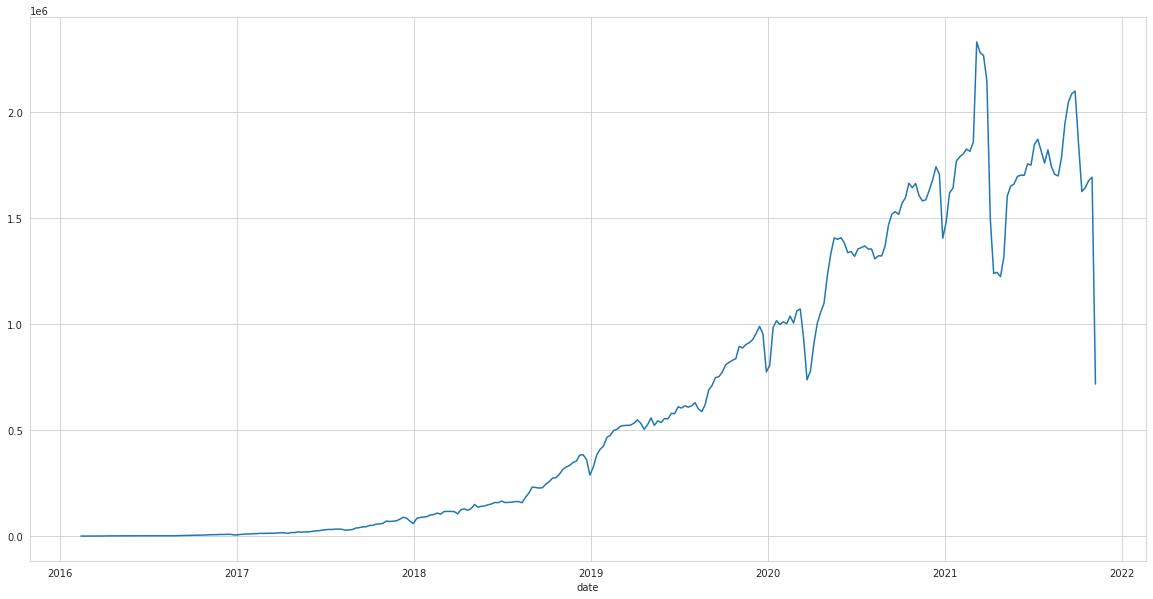

In [39]:
timetrendAll = ordersWithStores.resample('W').size().compute()

fig = plt.figure(figsize=(20, 10))
sns.lineplot(
    x=timetrendAll.index, 
    y=timetrendAll.values, 
)
plt.savefig('outputs/graphs/healthy_orders_timetrend_all.png', dpi=400)

In [11]:
healthyTags = [
    'Vegan / Vegetarian', 
    'Healthy', 
    'French,Healthy', 
    'International,Healthy', 
    'Healthy,French', 
    'Pizza & Italian,Healthy', 
    'Healthy,Japanese'
]
healthy = ordersWithStores[ordersWithStores.store_tag.isin(healthyTags)]
healthy.head()

,id,city,duration,total_distance,store_address_id,category,delivery_postal_code,hexagon_h3_hash_8,country_code,courier_id,time,store_creation_time,store_name,city_code,store_type,store_tag,is_food,store_segment,store_description,first_order_created,delivered_orders
date,,,,,,,,,,,,,,,,,,,,,
2016-02-15,33532,BCN,56.0,0.0,83.0,,NaN,88394460c7fffff,ES,X-5788-T,13:24:52,2016-02-11 13:01:50.000000,OH BO,BCN,RESTAURANT,Healthy,True,Other,Cocina de mercado,2016-02-15 13:24:52.000000,5118.0
2016-02-16,33994,MAD,57.0,0.0,77.0,,NaN,88390ca245fffff,ES,X-43971-T,21:33:39,2016-02-11 09:48:21.000000,Magasand,MAD,RESTAURANT,Healthy,True,Other,Alta cocina rápida,2016-02-16 21:33:39.000000,13902.0
2016-02-16,33897,BCN,29.0,0.0,65.0,,NaN,88394460c7fffff,ES,X-5214-T,16:46:18,2016-02-10 19:16:42.000000,Greenshots,BCN,RESTAURANT,Healthy,True,Other,La opción sana,2016-02-16 16:46:17.000000,603.0
2016-02-20,36043,MAD,56.0,0.0,77.0,,NaN,88390ca245fffff,ES,X-16278-T,16:10:38,2016-02-11 09:48:21.000000,Magasand,MAD,RESTAURANT,Healthy,True,Other,Alta cocina rápida,2016-02-16 21:33:39.000000,13902.0
2016-02-22,37207,MAD,45.0,0.0,77.0,,NaN,88390ca245fffff,ES,X-20941-T,21:07:14,2016-02-11 09:48:21.000000,Magasand,MAD,RESTAURANT,Healthy,True,Other,Alta cocina rápida,2016-02-16 21:33:39.000000,13902.0


In [15]:
timetrend = healthy.resample('W').size().compute()

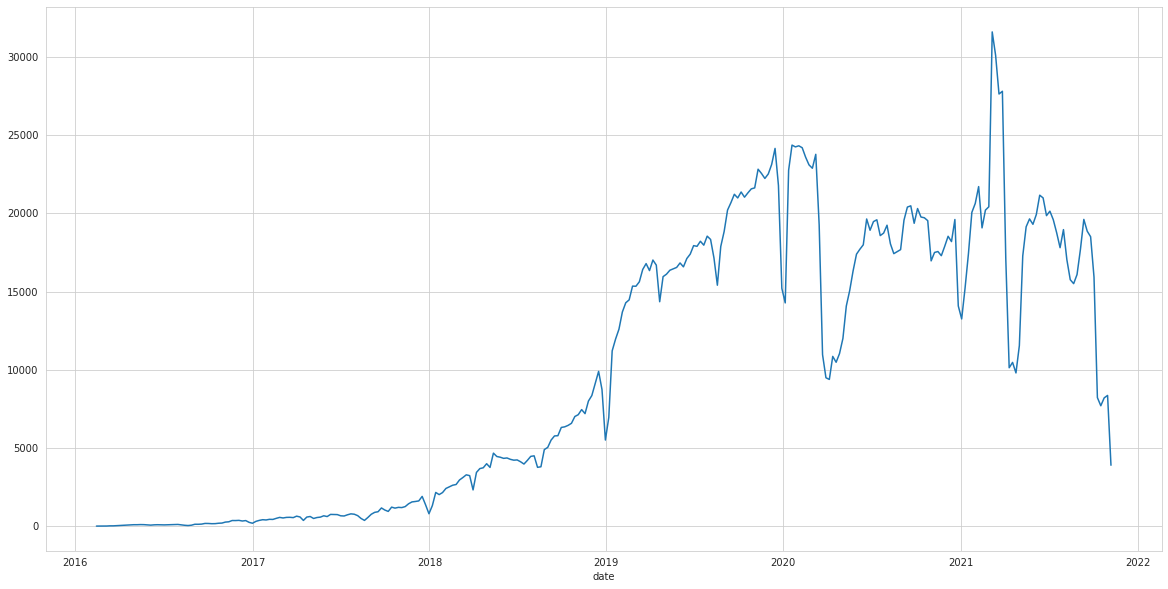

In [36]:
fig = plt.figure(figsize=(20, 10))
sns.lineplot(
    x=timetrend.index, 
    y=timetrend.values, 
)
plt.savefig('outputs/graphs/healthy_orders_timetrend.png', dpi=400)

In [22]:
byCountry = healthy.compute().groupby('country_code').resample('W').size()#.compute()
byCountry.head()

country_code  date      
AR            2018-01-28    23
              2018-02-04    40
              2018-02-11    33
              2018-02-18    36
              2018-02-25    30
dtype: int64

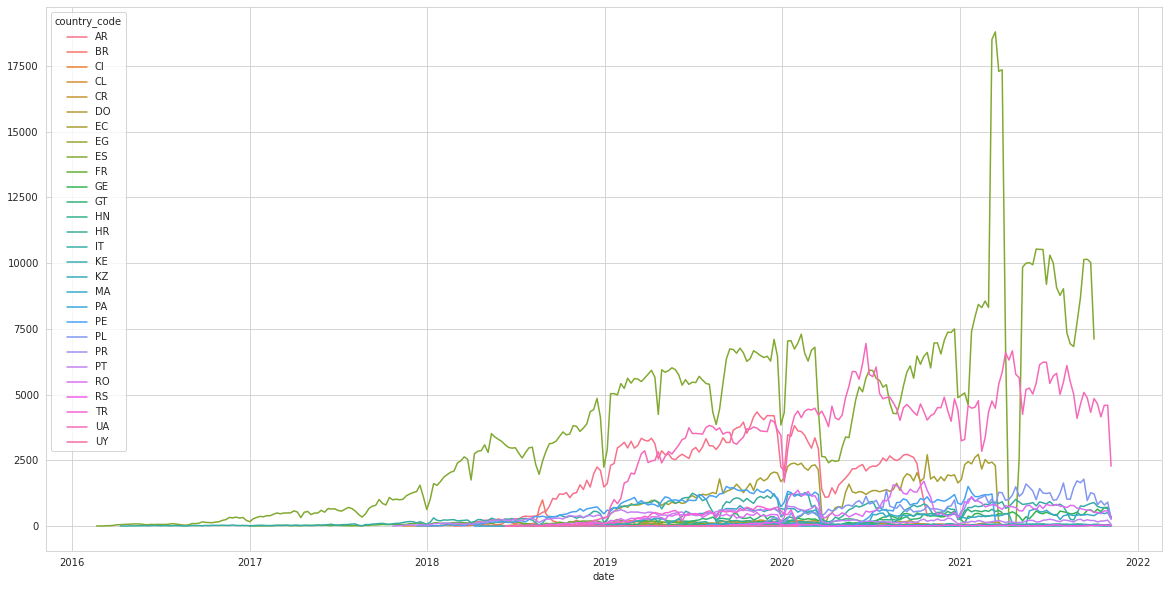

In [35]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(data=byCountry, x='date', y=byCountry.values, hue='country_code')
plt.savefig('outputs/graphs/healthy_orders_timetrend_byCountry.png', dpi=400)

In [7]:
seafoodTags = [
    'Seafood', 
    'Seafood,French'
]
seafood = ordersWithStores[ordersWithStores.store_tag.isin(seafoodTags)]
seafood.head()

,id,city,duration,total_distance,store_address_id,category,delivery_postal_code,hexagon_h3_hash_8,country_code,courier_id,time,store_creation_time,store_name,city_code,store_type,store_tag,is_food,store_segment,store_description,first_order_created,delivered_orders
date,,,,,,,,,,,,,,,,,,,,,
2017-01-27,440656,MIL,32.0,3.131,4800.0,GLOVOSIGNATURE,20159.0,881f99cc33fffff,IT,X-117582-T,12:36:44,2017-01-18 15:55:43.000000,Il Panino di mare di Pescaria,MIL,GLOVOSIGNATURE,Seafood,False,Other,Il panino di mare migliore che c'é,2017-01-27 12:36:44.000000,9.0
2017-01-28,444136,MIL,28.0,2.550,4800.0,,20159.0,881f99cc3bfffff,IT,X-263502-T,12:42:57,2017-01-18 15:55:43.000000,Il Panino di mare di Pescaria,MIL,GLOVOSIGNATURE,Seafood,False,Other,Il panino di mare migliore che c'é,2017-01-27 12:36:44.000000,9.0
2017-01-29,448683,MIL,62.0,6.693,4800.0,GLOVOSIGNATURE,20129.0,881f99ccadfffff,IT,X-245268-T,16:10:06,2017-01-18 15:55:43.000000,Il Panino di mare di Pescaria,MIL,GLOVOSIGNATURE,Seafood,False,Other,Il panino di mare migliore che c'é,2017-01-27 12:36:44.000000,9.0
2017-02-02,459891,MIL,63.0,5.348,4800.0,,20144.0,881f99cdc1fffff,IT,X-229879-T,21:40:47,2017-01-18 15:55:43.000000,Il Panino di mare di Pescaria,MIL,GLOVOSIGNATURE,Seafood,False,Other,Il panino di mare migliore che c'é,2017-01-27 12:36:44.000000,9.0
2017-02-05,468681,MIL,78.0,2.730,4800.0,GLOVOSIGNATURE,20122.0,881f99cd8bfffff,IT,X-155191-T,12:48:01,2017-01-18 15:55:43.000000,Il Panino di mare di Pescaria,MIL,GLOVOSIGNATURE,Seafood,False,Other,Il panino di mare migliore che c'é,2017-01-27 12:36:44.000000,9.0


In [8]:
timetrend = seafood.resample('W').size().compute()

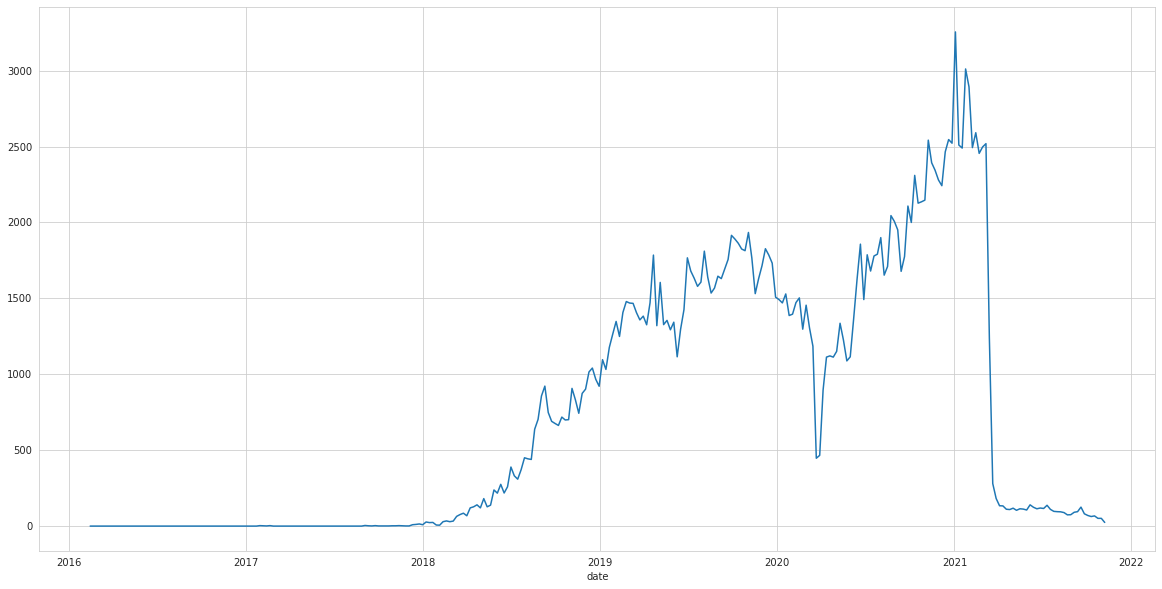

In [9]:
fig = plt.figure(figsize=(20, 10))
sns.lineplot(
    x=timetrend.index, 
    y=timetrend.values, 
)
plt.savefig('outputs/graphs/seafood_orders_timetrend.png', dpi=400)

In [ ]:
byCountry = seafood.compute().groupby('country_code').resample('W').size()#.compute()
byCountry.head()

In [ ]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(data=byCountry, x='date', y=byCountry.values, hue='country_code')
plt.savefig('outputs/graphs/seafood_orders_timetrend_byCountry.png', dpi=400)

In [ ]:
########################################################################################################################
##################################################### ukraine ##########################################################
########################################################################################################################

In [20]:
codeDict = {
    "AF": "Afghanistan",
    "AL": "Albania",
    "DZ": "Algeria",
    "AS": "American Samoa",
    "AD": "Andorra",
    "AO": "Angola",
    "AI": "Anguilla",
    "AQ": "Antarctica",
    "AG": "Antigua and Barbuda",
    "AR": "Argentina",
    "AM": "Armenia",
    "AW": "Aruba",
    "AU": "Australia",
    "AT": "Austria",
    "AZ": "Azerbaijan",
    "BS": "Bahamas (the)",
    "BH": "Bahrain",
    "BD": "Bangladesh",
    "BB": "Barbados",
    "BY": "Belarus",
    "BE": "Belgium",
    "BZ": "Belize",
    "BJ": "Benin",
    "BM": "Bermuda",
    "BT": "Bhutan",
    "BO": "Bolivia (Plurinational State of)",
    "BQ": "Bonaire, Sint Eustatius and Saba",
    "BA": "Bosnia and Herzegovina",
    "BW": "Botswana",
    "BV": "Bouvet Island",
    "BR": "Brazil",
    "IO": "British Indian Ocean Territory (the)",
    "BN": "Brunei Darussalam",
    "BG": "Bulgaria",
    "BF": "Burkina Faso",
    "BI": "Burundi",
    "CV": "Cabo Verde",
    "KH": "Cambodia",
    "CM": "Cameroon",
    "CA": "Canada",
    "KY": "Cayman Islands (the)",
    "CF": "Central African Republic (the)",
    "TD": "Chad",
    "CL": "Chile",
    "CN": "China",
    "CX": "Christmas Island",
    "CC": "Cocos (Keeling) Islands (the)",
    "CO": "Colombia",
    "KM": "Comoros (the)",
    "CD": "Congo (the Democratic Republic of the)",
    "CG": "Congo (the)",
    "CK": "Cook Islands (the)",
    "CR": "Costa Rica",
    "HR": "Croatia",
    "CU": "Cuba",
    "CW": "Curaçao",
    "CY": "Cyprus",
    "CZ": "Czechia",
    "CI": "Côte d'Ivoire",
    "DK": "Denmark",
    "DJ": "Djibouti",
    "DM": "Dominica",
    "DO": "Dominican Republic (the)",
    "EC": "Ecuador",
    "EG": "Egypt",
    "SV": "El Salvador",
    "GQ": "Equatorial Guinea",
    "ER": "Eritrea",
    "EE": "Estonia",
    "SZ": "Eswatini",
    "ET": "Ethiopia",
    "FK": "Falkland Islands (the) [Malvinas]",
    "FO": "Faroe Islands (the)",
    "FJ": "Fiji",
    "FI": "Finland",
    "FR": "France",
    "GF": "French Guiana",
    "PF": "French Polynesia",
    "TF": "French Southern Territories (the)",
    "GA": "Gabon",
    "GM": "Gambia (the)",
    "GE": "Georgia",
    "DE": "Germany",
    "GH": "Ghana",
    "GI": "Gibraltar",
    "GR": "Greece",
    "GL": "Greenland",
    "GD": "Grenada",
    "GP": "Guadeloupe",
    "GU": "Guam",
    "GT": "Guatemala",
    "GG": "Guernsey",
    "GN": "Guinea",
    "GW": "Guinea-Bissau",
    "GY": "Guyana",
    "HT": "Haiti",
    "HM": "Heard Island and McDonald Islands",
    "VA": "Holy See (the)",
    "HN": "Honduras",
    "HK": "Hong Kong",
    "HU": "Hungary",
    "IS": "Iceland",
    "IN": "India",
    "ID": "Indonesia",
    "IR": "Iran (Islamic Republic of)",
    "IQ": "Iraq",
    "IE": "Ireland",
    "IM": "Isle of Man",
    "IL": "Israel",
    "IT": "Italy",
    "JM": "Jamaica",
    "JP": "Japan",
    "JE": "Jersey",
    "JO": "Jordan",
    "KZ": "Kazakhstan",
    "KE": "Kenya",
    "KI": "Kiribati",
    "KP": "Korea (the Democratic People's Republic of)",
    "KR": "Korea (the Republic of)",
    "KW": "Kuwait",
    "KG": "Kyrgyzstan",
    "LA": "Lao People's Democratic Republic (the)",
    "LV": "Latvia",
    "LB": "Lebanon",
    "LS": "Lesotho",
    "LR": "Liberia",
    "LY": "Libya",
    "LI": "Liechtenstein",
    "LT": "Lithuania",
    "LU": "Luxembourg",
    "MO": "Macao",
    "MG": "Madagascar",
    "MW": "Malawi",
    "MY": "Malaysia",
    "MV": "Maldives",
    "ML": "Mali",
    "MT": "Malta",
    "MH": "Marshall Islands (the)",
    "MQ": "Martinique",
    "MR": "Mauritania",
    "MU": "Mauritius",
    "YT": "Mayotte",
    "MX": "Mexico",
    "FM": "Micronesia (Federated States of)",
    "MD": "Moldova (the Republic of)",
    "MC": "Monaco",
    "MN": "Mongolia",
    "ME": "Montenegro",
    "MS": "Montserrat",
    "MA": "Morocco",
    "MZ": "Mozambique",
    "MM": "Myanmar",
    "NA": "Namibia",
    "NR": "Nauru",
    "NP": "Nepal",
    "NL": "Netherlands (the)",
    "NC": "New Caledonia",
    "NZ": "New Zealand",
    "NI": "Nicaragua",
    "NE": "Niger (the)",
    "NG": "Nigeria",
    "NU": "Niue",
    "NF": "Norfolk Island",
    "MP": "Northern Mariana Islands (the)",
    "NO": "Norway",
    "OM": "Oman",
    "PK": "Pakistan",
    "PW": "Palau",
    "PS": "Palestine, State of",
    "PA": "Panama",
    "PG": "Papua New Guinea",
    "PY": "Paraguay",
    "PE": "Peru",
    "PH": "Philippines (the)",
    "PN": "Pitcairn",
    "PL": "Poland",
    "PT": "Portugal",
    "PR": "Puerto Rico",
    "QA": "Qatar",
    "MK": "Republic of North Macedonia",
    "RO": "Romania",
    "RU": "Russian Federation (the)",
    "RW": "Rwanda",
    "RE": "Réunion",
    "BL": "Saint Barthélemy",
    "SH": "Saint Helena, Ascension and Tristan da Cunha",
    "KN": "Saint Kitts and Nevis",
    "LC": "Saint Lucia",
    "MF": "Saint Martin (French part)",
    "PM": "Saint Pierre and Miquelon",
    "VC": "Saint Vincent and the Grenadines",
    "WS": "Samoa",
    "SM": "San Marino",
    "ST": "Sao Tome and Principe",
    "SA": "Saudi Arabia",
    "SN": "Senegal",
    "RS": "Serbia",
    "SC": "Seychelles",
    "SL": "Sierra Leone",
    "SG": "Singapore",
    "SX": "Sint Maarten (Dutch part)",
    "SK": "Slovakia",
    "SI": "Slovenia",
    "SB": "Solomon Islands",
    "SO": "Somalia",
    "ZA": "South Africa",
    "GS": "South Georgia and the South Sandwich Islands",
    "SS": "South Sudan",
    "ES": "Spain",
    "LK": "Sri Lanka",
    "SD": "Sudan (the)",
    "SR": "Suriname",
    "SJ": "Svalbard and Jan Mayen",
    "SE": "Sweden",
    "CH": "Switzerland",
    "SY": "Syrian Arab Republic",
    "TW": "Taiwan (Province of China)",
    "TJ": "Tajikistan",
    "TZ": "Tanzania, United Republic of",
    "TH": "Thailand",
    "TL": "Timor-Leste",
    "TG": "Togo",
    "TK": "Tokelau",
    "TO": "Tonga",
    "TT": "Trinidad and Tobago",
    "TN": "Tunisia",
    "TR": "Turkey",
    "TM": "Turkmenistan",
    "TC": "Turks and Caicos Islands (the)",
    "TV": "Tuvalu",
    "UG": "Uganda",
    "UA": "Ukraine",
    "AE": "United Arab Emirates (the)",
    "GB": "United Kingdom of Great Britain and Northern Ireland (the)",
    "UM": "United States Minor Outlying Islands (the)",
    "US": "United States of America (the)",
    "UY": "Uruguay",
    "UZ": "Uzbekistan",
    "VU": "Vanuatu",
    "VE": "Venezuela (Bolivarian Republic of)",
    "VN": "Viet Nam",
    "VG": "Virgin Islands (British)",
    "VI": "Virgin Islands (U.S.)",
    "WF": "Wallis and Futuna",
    "EH": "Western Sahara",
    "YE": "Yemen",
    "ZM": "Zambia",
    "ZW": "Zimbabwe",
    "AX": "Åland Islands",
    }

def getCoutryFromCode(code):
    return codeDict[code]

allCountries = orders.country_code.value_counts().to_frame().compute()
allCountries

,country_code
ES,70585652
RO,33115840
IT,31696084
UA,25230912
PE,17991286
AR,15292771
PT,11985984
PL,11441570
GE,10666129
MA,8833544


In [23]:
# allCountries = allCountries.reset_index()
# allCountries = allCountries.rename(columns={'index': 'country_code', 'country_code': 'count'})
allCountries['country'] = allCountries.country_code.apply(getCoutryFromCode)
allCountries

,country_code,count,country
0,ES,70585652,Spain
1,RO,33115840,Romania
2,IT,31696084,Italy
3,UA,25230912,Ukraine
4,PE,17991286,Peru
5,AR,15292771,Argentina
6,PT,11985984,Portugal
7,PL,11441570,Poland
8,GE,10666129,Georgia
9,MA,8833544,Morocco


In [34]:
easternCountriesCodes = [
    'RO', 
    'UA',
    'PL', 
    'GE', 
    'HR', 
    'RS', 
    'TR', 
    'BG', 
    'MD', 
    'ME', 
    'SI', 
    'BA', 
    'AM', 
    'BY',
]

countryOrderEvolutions = pd.DataFrame()

for code in tqdm(easternCountriesCodes):
    temp = orders.loc[orders.country_code == code].compute()
    
#     col = temp.reset_index().groupby('date').size()
    col = temp.resample('W').size()
    
    countryOrderEvolutions[getCoutryFromCode(code)] = col
    
countryOrderEvolutions

100%|██████████| 14/14 [16:19<00:00, 69.96s/it]


,Romania,Ukraine,Poland,Georgia,Croatia,Serbia,Turkey,Bulgaria,Moldova (the Republic of),Montenegro,Slovenia,Bosnia and Herzegovina,Armenia,Belarus
date,,,,,,,,,,,,,,
2018-05-20,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-27,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-03,296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-10,516,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-17,720,NaN,NaN,NaN,NaN,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-10,385545,308826.0,176773.0,124833.0,100880.0,149476.0,NaN,76165.0,10324.0,15312.0,26056.0,13287.0,247.0,15.0
2021-10-17,388883,303800.0,185747.0,126255.0,103288.0,145417.0,NaN,80167.0,9847.0,13655.0,26522.0,12768.0,601.0,122.0
2021-10-24,382834,308120.0,200363.0,135571.0,105371.0,148782.0,NaN,79007.0,9938.0,12852.0,27628.0,13316.0,806.0,165.0


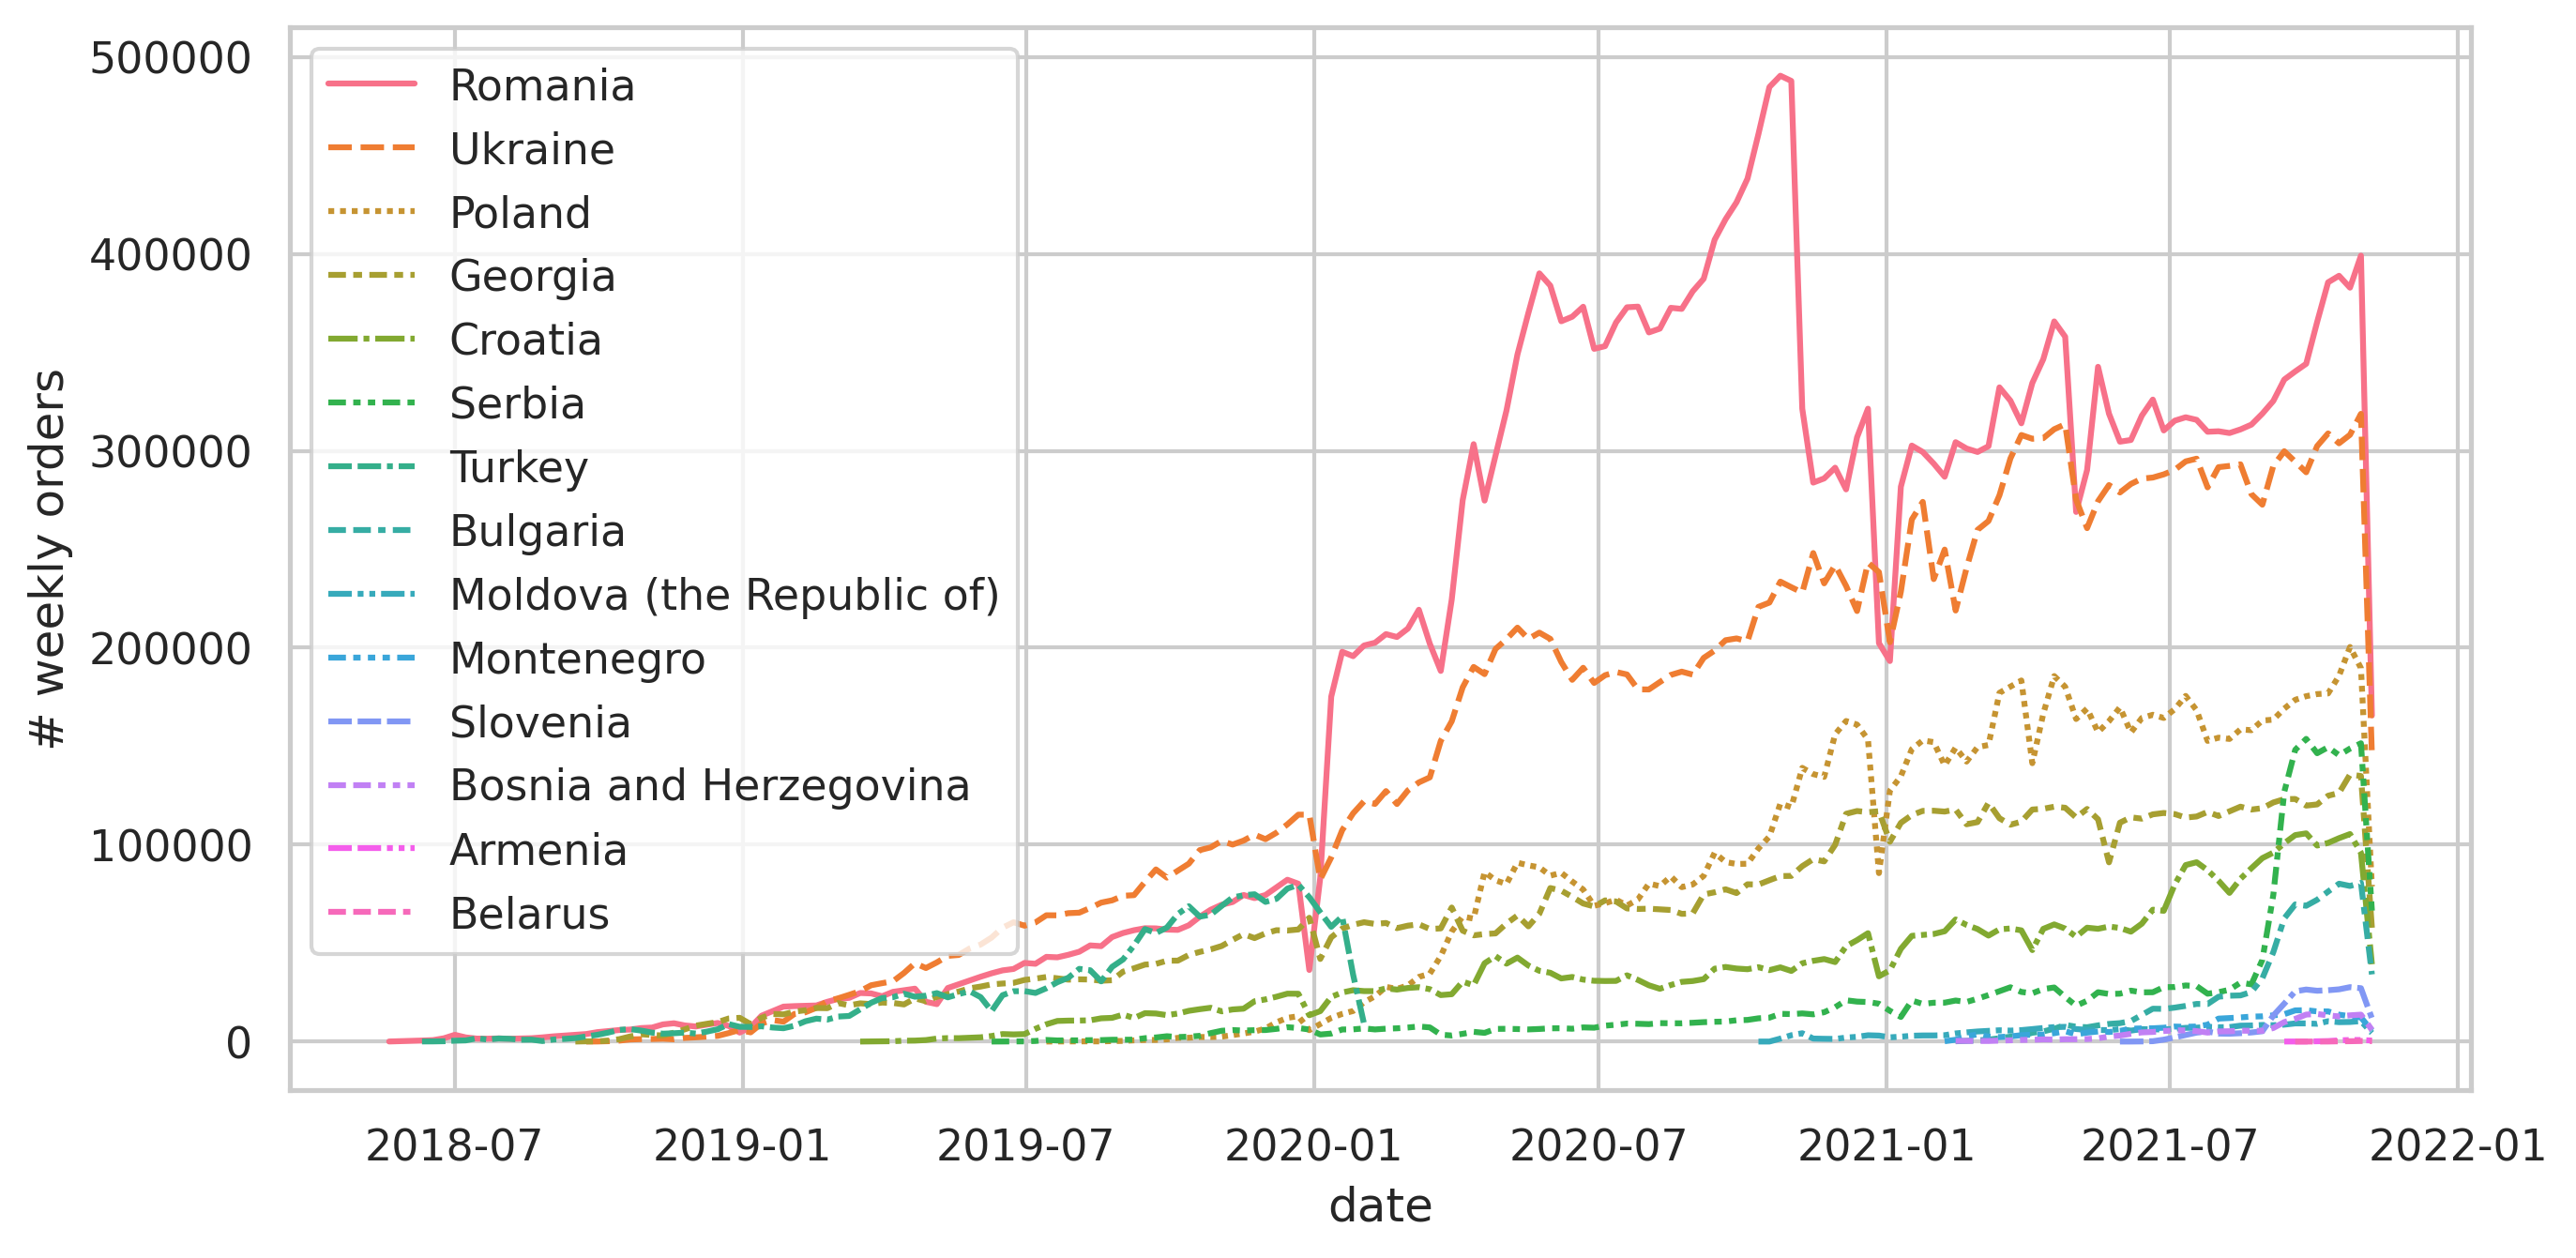

In [36]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.set_style("whitegrid")
sns.lineplot(data=countryOrderEvolutions, ax=ax)
ax.set_ylabel('# weekly orders')
plt.savefig('outputs/eastern_european_orders.png')

In [9]:
########################################################################################################################
##################################################### orders ###########################################################
########################################################################################################################

In [10]:
orders.head()

,id,city,duration,total_distance,store_address_id,category,delivery_postal_code,hexagon_h3_hash_8,country_code,courier_id,time
date,,,,,,,,,,,
2016-01-01,22154,BCN,47.0,0.0,NaN,QUIERO,NaN,,ES,X-27861-T,22:26:38
2016-01-01,22073,BCN,27.0,0.0,NaN,QUIERO,NaN,,ES,X-20890-T,20:11:02
2016-01-01,22123,MAD,50.0,0.0,NaN,QUIERO,NaN,,ES,X-7500-T,21:31:01
2016-01-01,22044,VAL,68.0,0.0,NaN,QUIERO,NaN,8839540a89fffff,ES,X-13621-T,15:22:10
2016-01-01,22153,MAD,30.0,0.0,NaN,QUIERO,NaN,88390cb19dfffff,ES,X-32616-T,22:26:09


In [11]:
# share of missings
(orders.isnull().sum()/len(orders)).compute()

id                      0.000000
city                    0.000000
duration                0.000000
total_distance          0.047652
store_address_id        0.076032
category                0.000000
delivery_postal_code    0.328730
hexagon_h3_hash_8       0.000000
country_code            0.000000
courier_id              0.000000
time                    0.000000
dtype: float64

In [12]:
# number of orders in all years, all countries
len(orders)

288094514

In [13]:
# country distribution of orders
orders.country_code.value_counts().compute()

ES    70585652
RO    33115840
IT    31696084
UA    25230912
PE    17991286
AR    15292771
PT    11985984
PL    11441570
GE    10666129
MA     8833544
EC     8121984
KZ     6542369
CR     6266935
HR     5325669
GT     4069875
RS     2721852
CI     2510319
KE     2475794
TR     2220480
EG     1552963
PA     1164913
FR     1152577
DO     1054735
BR     1036614
BG     1001101
CL      901841
HN      798067
GH      410069
MD      316356
ME      311658
KG      275191
SI      267705
UY      231864
UG      204858
BA      198901
PR      108686
NG        7410
AM        3172
BY         782
CO           2
Name: country_code, dtype: int64

In [14]:
# city distribution of orders
orders.city.value_counts().compute()[:30]

MAD    19667736
BUC    19136196
BCN    18122576
LIM    16082251
MIL    10606601
BUE    10187300
TBI     9513030
KIE     8374383
ROM     7976661
SJO     6244412
LIS     5188783
ALA     4780791
TOR     4617325
KYI     4240218
CAS     4026709
GTM     3946950
QUI     3713518
VAL     3682720
ZAG     3477583
GYE     3459564
WAW     2549268
NBO     2253041
KHA     2209974
TIM     2085476
ZAR     2081197
RBT     2056232
CLJ     2010317
ODS     2000710
BRV     1975870
OPO     1967697
Name: city, dtype: int64

In [15]:
# number of all orders in all countries over the years
# ddf['orders'] = 1
# ddf.groupby('date')['orders'].sum().compute()

# orders.resample('D').count().compute()

In [16]:
########################################################################################################################
##################################################### stores ###########################################################
########################################################################################################################

In [17]:
stores.head()

,store_address_id,store_creation_time,store_name,city_code,store_type,store_tag,is_food,store_segment,store_description,first_order_created,delivered_orders
store_id,,,,,,,,,,,
1,NaN,2016-01-21 13:49:32.000000,Pizza Market,BCN,RESTAURANT,,True,Local Hero,good pizza,,0.0
2,NaN,2016-01-21 13:54:23.000000,McDonalds,BCN,RESTAURANT,,True,Big Chain,good burgers?,,0.0
3,NaN,2016-01-21 13:54:23.000000,Sushi Place,BCN,RESTAURANT,,True,Other,raw fish,,0.0
4,NaN,2016-01-21 13:54:23.000000,Chinese,BCN,RESTAURANT,,True,Other,noodles and other things,,0.0
5,167934.0,2016-01-21 13:54:23.000000,Pedidos Especiales Parafarmacia,BCN,PHARMACYIBERIA,,False,Other,,2016-02-14 16:53:33.000000,0.0


In [18]:
# share of missings
(stores.isnull().sum()/len(stores)).compute()

store_address_id       0.014312
store_creation_time    0.000000
store_name             0.000000
city_code              0.000000
store_type             0.000000
store_tag              0.000000
is_food                0.000000
store_segment          0.000000
store_description      0.000000
first_order_created    0.000000
delivered_orders       0.000000
dtype: float64

In [19]:
stores.store_tag.value_counts().compute()

                                 199665
Burger                             9160
Groceries                          8688
Snacks                             7657
Pizza & Italian                    6543
Pizza                              4830
Japanese                           3990
Pharmacy                           3082
Turkish                            2633
Chicken                            2559
Healthy                            2286
Latin                              2078
Italian                            1805
Sweets                             1756
International                      1676
American                           1602
Brazilian                          1568
Mexican                            1497
Gifts                              1477
Asian                              1447
Sandwich                           1296
Icecream                           1072
Regalo (Gifts)                      878
Grill (Barbeque)                    867
Chinese                             859


In [20]:
# store_tags by order volume
# ordersWithStores.store_tag.value_counts().to_csv('outputs/storeTags_by_order_volume.csv', single_file=True)
pd.read_csv('outputs/storeTags_by_order_volume.csv')


,Unnamed: 0,store_tag
0,NaN,75679853
1,Burger,28749773
2,Chicken,8504049
3,Groceries,8250849
4,Snacks,7453337
5,Pizza & Italian,6212564
6,Pizza,5907801
7,Japanese,4789271
8,Fast Food,4577693
9,Asian,3563088


In [21]:
########################################################################################################################
#################################################### couriers ##########################################################
########################################################################################################################

In [22]:
couriers.head()

,city,rating,efficiency,first_order_date,last_order_date,transport,is_electric,first_order_id,last_order_id,total_distance_driven,number_of_delivered_orders
courier_id,,,,,,,,,,,
208,BCN,4.6182,1.650000,2015-02-14 02:32:51.000000,2021-09-20 20:17:47.000000,BICYCLE,Yes,767,289711565,269.931,157.0
218,BCN,4.5294,1.000000,2015-04-18 22:35:37.000000,2016-01-25 15:56:16.000000,BICYCLE,No,1363,27464,0.000,29.0
225,BCN,4.5827,1.428571,2015-02-22 22:02:48.000000,2015-08-01 21:17:12.000000,BICYCLE,No,815,4358,0.000,151.0
231,BCN,0.0000,1.395349,2015-04-26 23:18:22.000000,2015-10-17 14:15:53.000000,BICYCLE,No,1566,8455,0.000,13.0
242,MAD,5.0000,1.350000,2015-11-13 19:02:16.000000,2016-01-22 16:49:10.000000,WALKER,No,11800,26717,0.000,7.0


In [23]:
# share of missings
(couriers.isnull().sum()/len(couriers)).compute()

city                          0.000000
rating                        0.000000
efficiency                    0.000000
first_order_date              0.000000
last_order_date               0.000000
transport                     0.000000
is_electric                   0.000000
first_order_id                0.000000
last_order_id                 0.000000
total_distance_driven         0.186842
number_of_delivered_orders    0.000000
dtype: float64